# COVID-19 Rates By Municipalities in Mexico
[Work in progress]

This notebooks uses data from [COVID-19 Mexico, Gobierno de Mexico](https://coronavirus.gob.mx/datos)

In [1]:
import math
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
from py2neo import Graph
import ipywidgets as widgets

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

#### Setup dropdown menus

In [4]:
query = """
// get list of state in Mexico
MATCH (a:Admin1)-[:IN]->(c:Country{name: 'Mexico'})
RETURN a.name as state
ORDER BY state
"""
states = graph.run(query).to_data_frame()['state'].values

In [5]:
state_widget = widgets.Dropdown(options=states, description='Select state:', value='Baja California')
metric_widget = widgets.Dropdown(options=('confirmedRate', 'deathRate'), description='Select metric')

### Query KG to get Confirmed Cases, Deaths, and Population for Counties in a State

In [6]:
display(state_widget)

Dropdown(description='Select state:', index=1, options=('Aguascalientes', 'Baja California', 'Baja California …

In [7]:
display(metric_widget)

Dropdown(description='Select metric', options=('confirmedRate', 'deathRate'), value='confirmedRate')

In [8]:
state = state_widget.value
metric = metric_widget.value
print('State :', state)
print('Metric:', metric)

State : Baja California
Metric: confirmedRate


In [9]:
# start date for time series
start_date = '2020-04-01'

#### Get confirmed cases and deaths for all counties in a state

In [10]:
query = """
// get all municipalities (admin1) in a state
MATCH (a:Admin2)-[:IN]->(:Admin1{name: $state})

// get COVID-19 cases for all states
MATCH (a)<-[:REPORTED_IN]-(c:Cases{source: 'GOBMX', aggregationLevel: 'Admin2'}) 
WHERE c.date >= date($start_date)

RETURN a.name AS name, c.date AS date, 
       c.cases*100000.0/c.population AS confirmedRate, 
       c.deaths*100000.0/c.population AS deathRate,
       c.cases AS cases,
       c.deaths AS deaths,
       c.population AS population
ORDER BY c.date ASC, a.name
"""
df = graph.run(query, state=state, start_date=start_date).to_data_frame()

In [11]:
df.tail(5)

,name,date,confirmedRate,deathRate,cases,deaths,population
691,Mexicali,2020-08-30,772.521375,136.922310,8401,1489,1087478
692,Playas de Rosarito,2020-08-30,252.181088,30.595500,272,33,107859
693,Tijuana,2020-08-30,294.322926,71.303599,5267,1276,1789531
694,Ensenada,2020-08-31,487.183457,59.872086,2612,321,536143
695,Mexicali,2020-08-31,772.705287,137.014266,8403,1490,1087478


Reformat data

In [12]:
# convert neo4j date object to datetime
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=False)  
# pivot table
df_date = df.pivot(index='date', columns='name', values=metric)
df_date.fillna(0, inplace=True)
df_date.tail()

name,Ensenada,Mexicali,Playas de Rosarito,Tecate,Tijuana
date,,,,,
2020-08-27,485.318283,771.233993,251.253952,0.0,293.764120
2020-08-28,486.623904,772.061596,252.181088,0.0,294.211165
2020-08-29,486.810422,772.521375,0.000000,0.0,294.322926
2020-08-30,486.810422,772.521375,252.181088,0.0,294.322926
2020-08-31,487.183457,772.705287,0.000000,0.0,0.000000


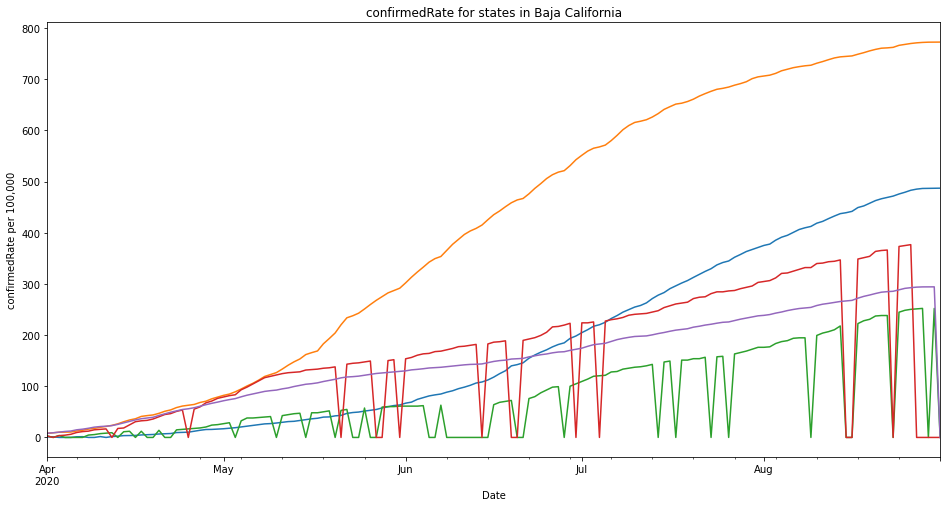

In [13]:
ax = df_date.plot(figsize=(16, 8), legend=False, title=f'{metric} for states in {state}');
ax.set_xlabel('Date');
ax.set_ylabel(f'{metric} per 100,000');

### Case rates by Municipality

In [14]:
# dimensions for subplot layout
cols = 5
rows = math.ceil(df_date.shape[1]/cols)

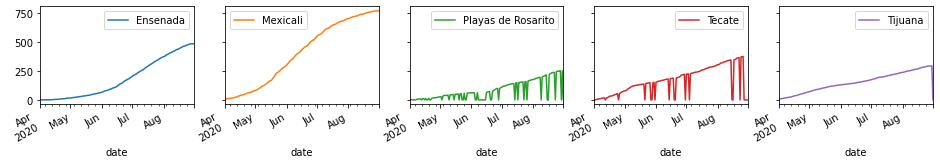

In [15]:
ax = df_date.plot(subplots=True, layout=(rows,cols), sharey=True, figsize=(16, 2*rows));